/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Epoch 1/50, Training Loss: 0.035346
Epoch 2/50, Training Loss: 0.020018
Epoch 3/50, Training Loss: 0.013193
Epoch 4/50, Training Loss: 0.011248
Epoch 5/50, Training Loss: 0.008747
Epoch 6/50, Training Loss: 0.007782
Epoch 7/50, Training Loss: 0.006684
Epoch 8/50, Training Loss: 0.005908
Epoch 9/50, Training Loss: 0.005257
Epoch 10/50, Training Loss: 0.004712
Epoch 11/50, Training Loss: 0.004191
Epoch 12/50, Training Loss: 0.003726
Epoch 13/50, Training Loss: 0.003345
Epoch 14/50, Training Loss: 0.003394
Epoch 15/50, Training Loss: 0.002926
Epoch 16/50, Training Loss: 0.002965
Epoch 17/50, Training Loss: 0.002526
Epoch 18/50, Training Loss: 0.002458
Epoch 19/50, Training Loss: 0.002345
Epoch 20/50, Training Loss: 0.001888
Epoch 21/50, Training Loss: 0.002216
Epoch 22/50, Training Loss: 0.001792
Epoch 23/50, Training Loss: 0.001628
Epoch 24/50, Training Loss: 0.001612
Epoch 25/50, Training Loss: 0.001699
Epoch 26/50, Training Loss: 0.001534
Epoch 27/50, Training Loss: 0.001473
Epoch 28/5

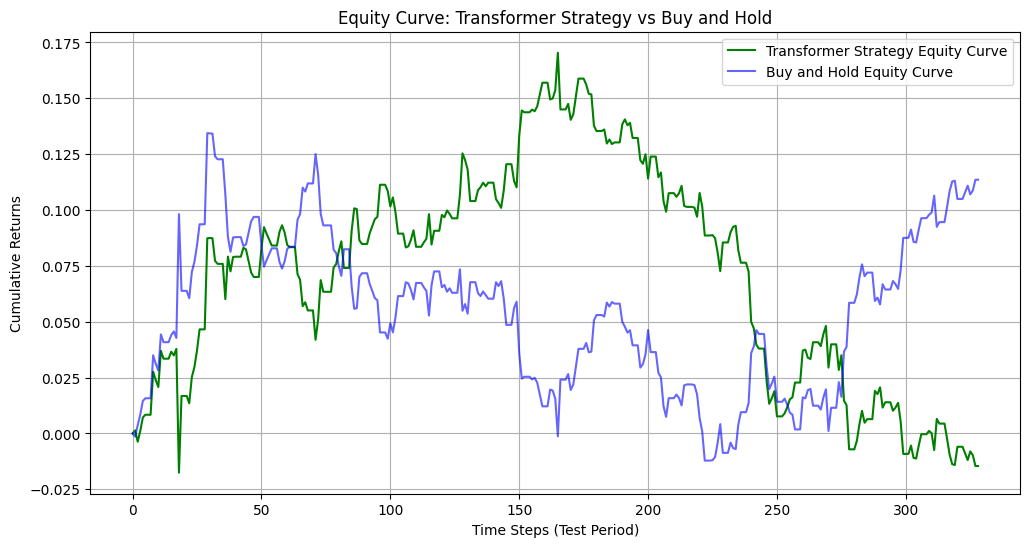

In [2]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

# Load data
df = pd.read_csv("Preprocessed_Data_with_features.csv")

# -- Prepare dataset for Transformer --

class TimeSeriesDataset(Dataset):
    def __init__(self, X, y, seq_length=30):
        self.X = X
        self.y = y
        self.seq_length = seq_length

    def __len__(self):
        return len(self.X) - self.seq_length

    def __getitem__(self, idx):
        return (self.X[idx:idx+self.seq_length], self.y[idx+self.seq_length])

# -- Define Transformer Model --

class TransformerRegressor(nn.Module):
    def __init__(self, feature_size, num_layers=2, num_heads=3, dropout=0.1, forward_expansion=4):
        super(TransformerRegressor, self).__init__()
        self.positional_encoding = nn.Parameter(torch.zeros(1, 500, feature_size))  # max seq length 500

        encoder_layer = nn.TransformerEncoderLayer(d_model=feature_size, nhead=num_heads,
                                                   dim_feedforward=feature_size*forward_expansion,
                                                   dropout=dropout, batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        self.regressor = nn.Linear(feature_size, 1)

    def forward(self, x):
        seq_len = x.size(1)
        x = x + self.positional_encoding[:, :seq_len, :]
        x = self.transformer_encoder(x)
        out = self.regressor(x[:, -1, :])  # Use last time step output for regression
        return out.squeeze()

# -- Load and preprocess your data --

features = ['SMA_20', 'EMA_20', 'RSI_14', 'MACD', 'MACD_signal', 'Bollinger_High', 'Bollinger_Low', 'ATR_14', 'Momentum_10']
target = 'Return'

# Assuming df is your cleaned DataFrame with these columns
X = df[features].values
y = df[target].values

# Scale features (important for Transformer)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train/test split (80/20)
split_idx = int(len(df) * 0.8)
X_train, X_test = X_scaled[:split_idx], X_scaled[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

seq_length = 30  # sequence length for Transformer input

train_dataset = TimeSeriesDataset(torch.tensor(X_train, dtype=torch.float32),
                                  torch.tensor(y_train, dtype=torch.float32), seq_length)
test_dataset = TimeSeriesDataset(torch.tensor(X_test, dtype=torch.float32),
                                 torch.tensor(y_test, dtype=torch.float32), seq_length)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# -- Initialize model, loss, optimizer --

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = TransformerRegressor(feature_size=len(features)).to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# -- Training loop --

num_epochs = 50

for epoch in range(num_epochs):
    model.train()
    train_losses = []
    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())
    print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {np.mean(train_losses):.6f}")

# -- Evaluation on test set --

model.eval()
y_pred = []
y_true = []

with torch.no_grad():
    for batch_X, batch_y in test_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        outputs = model(batch_X)
        y_pred.extend(outputs.cpu().numpy())
        y_true.extend(batch_y.cpu().numpy())

y_pred = np.array(y_pred)
y_true = np.array(y_true)

# Calculate Test MSE
test_mse = mean_squared_error(y_true, y_pred)

# Sharpe Ratio function
def sharpe_ratio(returns):
    mean_ret = np.mean(returns)
    std_ret = np.std(returns)
    return (mean_ret / std_ret) * np.sqrt(252)

# Strategy returns: long if predicted return > 0 else short
strategy_returns = np.where(y_pred > 0, y_true, -y_true)

# Sharpe Ratio
sharpe = sharpe_ratio(strategy_returns)

# Max Drawdown
cumulative_returns = np.cumsum(strategy_returns)
running_max = np.maximum.accumulate(cumulative_returns)
drawdown = cumulative_returns - running_max
max_drawdown = drawdown.min()

print(f"Transformer Test MSE: {test_mse:.6f}")
print(f"Transformer Sharpe Ratio: {sharpe:.4f}")
print(f"Transformer Max Drawdown: {max_drawdown:.4f}")

# Plot equity curve
plt.figure(figsize=(12,6))
plt.plot(cumulative_returns, label='Transformer Strategy Equity Curve', color='green')
plt.plot(np.cumsum(y_true), label='Buy and Hold Equity Curve', color='blue', alpha=0.6)
plt.title('Equity Curve: Transformer Strategy vs Buy and Hold')
plt.xlabel('Time Steps (Test Period)')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.grid(True)
plt.show()


**Buy-and-Hold**: Performs strongly positive with steady growth and decent cumulative return.

**Transformer Strategy**:

* Shows consistent underperformance with mostly negative cumulative returns.

* Appears highly sensitive to noise and reactive, leading to frequent poor trades.
* Never recovers from early losses, creating a "death spiral" pattern.

In [3]:
import pickle
from google.colab import files

# Save the model
with open('Transformer_model.pkl', 'wb') as f:
    pickle.dump(model, f)

# Download the file to your PC
files.download('Transformer_model.pkl')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>